In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gmaps
from datetime import datetime
import googlemaps
import numpy as np
import random
import datetime
from collections import namedtuple

## Evaluation of the Algorithm

- reference: API GM
- itinerarion: fermate e orario
- confrontare i risultati sulla basi di criteri: tempo totale che ci mette la soluzione vs GM, numero di cambi, distanza fatta piedi, distanza percorso.
- centinaio di itinerari
- plots

open the API of Google maps

In [2]:
with open('APIkey.txt') as f:
    api_key = f.readline()
    f.close

# Create an instance of the Google Maps client
gmaps = googlemaps.Client(key=api_key)

Load the data we need.
- longitude and latitude for Google Maps
- stops ids for CSA
- arrival time and departure time in seconds of the day for CSA
- arrival time and departure time in datetime object for Google Maps.

In [3]:
stops = pd.read_csv('stops_with_lonlat.csv')
stops = stops[['stop_id1', 'stop_id2', 'latitude1', 'longitude1', 'latitude2', 'longitude2']]
stops.shape

(917, 6)

In [4]:
stops_CSA = stops[['stop_id1', 'stop_id2']]
stops_GM = stops[['latitude1', 'longitude1', 'latitude2', 'longitude2']]

arr_time_CSA = random.sample(list(np.arange(21600,72000, dtype=float)), 900)

# Convert departure times to datetime objects
arr_time_GM = []
for seconds in arr_time_CSA:
    dt = datetime.datetime.utcfromtimestamp(seconds)
    arr_time_GM.append(dt)

## Function for comparing Google Maps and CSA


## Import the CSA algorithm

In [5]:
from array import array

def reset_timetable(timetable, original_length):
    for id, conn in enumerate(timetable):
        timetable[id] = conn._replace(active = 1)
    return timetable[:original_length]
### WORKING CSA
def CSA(stations, timetable, departure_station, departure_time, arrival_station, arrival_time):
    MAX_INT = 2**32 - 1

    earliest = MAX_INT
    
    in_connection = {s: MAX_INT for s in stations}
    earliest_arrival = {s: MAX_INT for s in stations}
    
    earliest_arrival[departure_station] = departure_time
    
    if transfer_dict.get(departure_station) is not None:
        for reachable_station, transfer_time in transfer_dict[departure_station]:
            arrival_time_reachable = departure_time + transfer_time
            earliest_arrival[reachable_station] = arrival_time_reachable
            walking_connection = Connection('W', departure_station, reachable_station, departure_time, arrival_time_reachable, 'W', 1)
            timetable.append(walking_connection)
            in_connection[reachable_station] = len(timetable) - 1 #get last index of timetable
    
    for i, c in enumerate(timetable):
        
        change = 0
        
        if c.active == 1:
            
            if (in_connection.get(c.dep_stop) is not None): #sanity
                if (in_connection[c.dep_stop] != MAX_INT):
                    #print(i, in_connection[c.dep_stop])
                    if (timetable[in_connection[c.dep_stop]].trip_id != c.trip_id):
                            change = 120 #transfer time penalty in seconds

            if (c.dep_time_sec >= earliest_arrival[c.dep_stop] + change) & (c.arr_time_sec < earliest_arrival[c.arr_stop]):
                
                
                earliest_arrival[c.arr_stop] = c.arr_time_sec
                in_connection[c.arr_stop] = i

                if c.arr_stop == arrival_station:
                    earliest = min(earliest, c.arr_time_sec)

                ## transfers
                if transfer_dict.get(c.arr_stop) is not None: ### inconsistency between the tables
                        for reachable_station, transfer_time in transfer_dict[c.arr_stop]:
                            arrival_time_reachable = c.arr_time_sec + transfer_time
                            if reachable_station in stations: ### inconsistency 
                                if (arrival_time_reachable < earliest_arrival[reachable_station]):
                                    
                                    earliest_arrival[reachable_station] = arrival_time_reachable
                                    # Append the 'walking' as a new connection to the timetable
                                    walking_connection = Connection('W', c.arr_stop, reachable_station, c.arr_time_sec, arrival_time_reachable, 'W', 1)
                                    #print(walking_connection)
                                    timetable.append(walking_connection)
                                    in_connection[reachable_station] = len(timetable) - 1 #get last index of timetable

                                    if reachable_station == arrival_station:
                                        earliest = min(earliest, arrival_time_reachable)

            elif c.arr_time_sec > earliest:
                break

    route = []
    # We have to rebuild the route from the arrival station
    last_connection_index = in_connection[arrival_station]

    while last_connection_index != MAX_INT:
        connection = timetable[last_connection_index]
        route.append(connection)
        last_connection_index = in_connection[connection.dep_stop]
    
    route=list(reversed(route))
    
    return route

## Retrieve the data in order to be able to run CSA

Stop transfers.

In [6]:
transfer_times = pd.read_csv('df_with_transfer_time.csv')
transfer_times['stop_id1'] = transfer_times['stop_id1'].astype('string')
transfer_times['stop_id2'] = transfer_times['stop_id2'].astype('string')

transfer_dict = {}
for _, row in transfer_times.iterrows():
    if row.stop_id1 not in transfer_dict:
        transfer_dict[row.stop_id1] = [(row.stop_id2, row.walking_time)]
    elif (row.stop_id2, row.walking_time) not in transfer_dict[row.stop_id1]:
        transfer_dict[row.stop_id1].append((row.stop_id2, row.walking_time))

Timetable data:

In [7]:
timetable = pd.read_pickle('timetable_zh_latest.pkl')
timetable.columns = ['stop_id', 'trip_id', 'stop_name', 'dep_stop', 'arr_stop',
       'dep_time', 'arr_time', 'route_desc', 'monday',
       'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
timetable["active"] = 1

def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

timetable['dep_time_sec'] = timetable['dep_time'].apply(get_sec)
timetable['arr_time_sec'] = timetable['arr_time'].apply(get_sec)
timetable.drop('dep_time', axis=1, inplace=True)
timetable.drop('arr_time', axis=1, inplace=True)

columns_to_compare = ['dep_stop', 'arr_stop', 'monday', 'tuesday', 'wednesday','thursday', 'friday', 'saturday', 'sunday', 'dep_time_sec','arr_time_sec']
duplicates = timetable.duplicated(subset=columns_to_compare, keep=False) 
timetable = timetable[~duplicates]
wrong_entries = timetable['arr_time_sec'] <= timetable['dep_time_sec'] ## added
timetable = timetable[~wrong_entries]
timetable['trip_id'] = timetable['trip_id'].astype('string')
timetable['dep_stop'] = timetable['dep_stop'].astype('string')
timetable['arr_stop'] = timetable['arr_stop'].astype('string')

Connection = namedtuple('connection', ['trip_id', 'dep_stop', 'arr_stop', 'dep_time_sec', 'arr_time_sec', 'route_desc', 'active'])
cols = ['trip_id', 'dep_stop', 'arr_stop', 'dep_time_sec', 'arr_time_sec', 'route_desc']
timetable_monday = timetable[timetable['monday'] == 1][cols].sort_values(by = 'dep_time_sec').reset_index(drop = True)

ls_timetable = []
for _, connection in timetable_monday.iterrows():
    ls_timetable.append(Connection(connection.trip_id, connection.dep_stop, connection.arr_stop, connection.dep_time_sec, connection.arr_time_sec, connection.route_desc, 1))
original_length = len(ls_timetable)

Stations.

In [8]:
df_zurich = pd.read_csv('df_zurich.csv')
stations = set(df_zurich['stop_id'].to_list() + timetable['dep_stop'].to_list() + timetable['arr_stop'].to_list())

## Run the evaluation function.

In [9]:
def performance_csa_compared_googlemaps(stations, testing_df, arr_time_CSA, arr_time_GM, ls_timetable, print_ = False):
    diff_duration_list = []
    diff_walking_list = []
    diff_nchanges_list = []
    
    needs_more_time = 0
    won = 0

    for i in range(0,900):        
        # get the longitude and latitude of the stops
        stop1, lon1, lat1 = row = testing_df.loc[i, ['stop_id1', 'latitude1', 'longitude1']]
        stop2, lon2, lat2 = row = testing_df.loc[i, ['stop_id2', 'latitude2', 'longitude2']]  
        departure_time = int(arr_time_CSA[i] - 10800)
        arrival_time = int(arr_time_CSA[i])
        
        # Google Maps directions
        directions_result = gmaps.directions(f"{lon1}, {lat1}", f"{lon2}, {lat2}",
                                            mode="driving",
                                            arrival_time = arr_time_GM[i])
        
        # CSA directions
        directions_result_csa = CSA(stations, ls_timetable, stop1, departure_time, stop2, arrival_time)
        
        if len(directions_result_csa) == 0:
            if print_ == True:
                print(f'The connection {i} from stop {stop1} to {stop2} at time {departure_time} to {arrival_time} does not exist, sorry!')
            needs_more_time += 1
            continue

        ##### TIME OF THE TRIP #####
        duration_gm = directions_result[0]['legs'][0]['duration']['text'].split(' ')
        total_duration_gm = float(duration_gm[0]) * 60     #Google Maps
        if len(duration_gm) > 2:
             total_duration_gm += int(duration_gm[2])
        total_duration_csa = - directions_result_csa[0].dep_time_sec + directions_result_csa[-1].arr_time_sec   # CSA
        
        if total_duration_csa > 10800:
            if print_ == True:
                print(f'The connection {i} from stop {stop1} to {stop2} at time {departure_time} to {arrival_time} needs a greater time frame.')
            needs_more_time += 1
            continue
            
        # FUNCTION FOR Google Maps
        walking_distance_gm, n_changes_gm = 0, 0
        for step in directions_result[0]['legs'][0]['steps']:
            if 'transit_details' in step:
                n_changes_gm += 1
            else:
                walking_distance_gm += step['distance']['value']
                
        # FUNCTION FOR CSA
        walking_distance_csa, n_changes_csa = 0.0, 0
        for j in range(len(directions_result_csa)):
            if directions_result_csa[j].trip_id == 'W':
                walking_distance_csa += (directions_result_csa[j].arr_time_sec - directions_result_csa[j].dep_time_sec) / 60 * 50
            n_changes_csa += 1

        # compute the differences and append them to the list
        diff_duration = total_duration_gm - total_duration_csa
        diff_walking = walking_distance_gm - walking_distance_csa
        diff_nchanges = n_changes_gm - 1 - n_changes_csa
        
        diff_duration_list.append(diff_duration)
        diff_walking_list.append(diff_walking)
        diff_nchanges_list.append(diff_nchanges)
    
    print(f'On average we found {100 - (needs_more_time / 900 * 100)} % connections in the time frame of 3h.')
    
    return diff_duration_list, diff_walking_list, diff_nchanges_list

In [10]:
diff_duration_list, diff_walking_list, diff_nchanges_list = performance_csa_compared_googlemaps(stations,
                                                                                                stops,
                                                                                                arr_time_CSA, 
                                                                                                arr_time_GM, 
                                                                                                ls_timetable,
                                                                                                print_ = False)

On average we found 96.22222222222223 % connections in the time frame of 3h.


### Plot of the differences

In [14]:
# convert from seconds to minutes for better readability in the plots:

def seconds_to_minutes(seconds_list):
    minutes_list = []
    for seconds in seconds_list:
        minutes = float(seconds) / 60.0
        minutes_list.append(minutes)
    return minutes_list

diff_duration_list = seconds_to_minutes(diff_duration_list)
diff_walking_list = seconds_to_minutes(diff_walking_list)

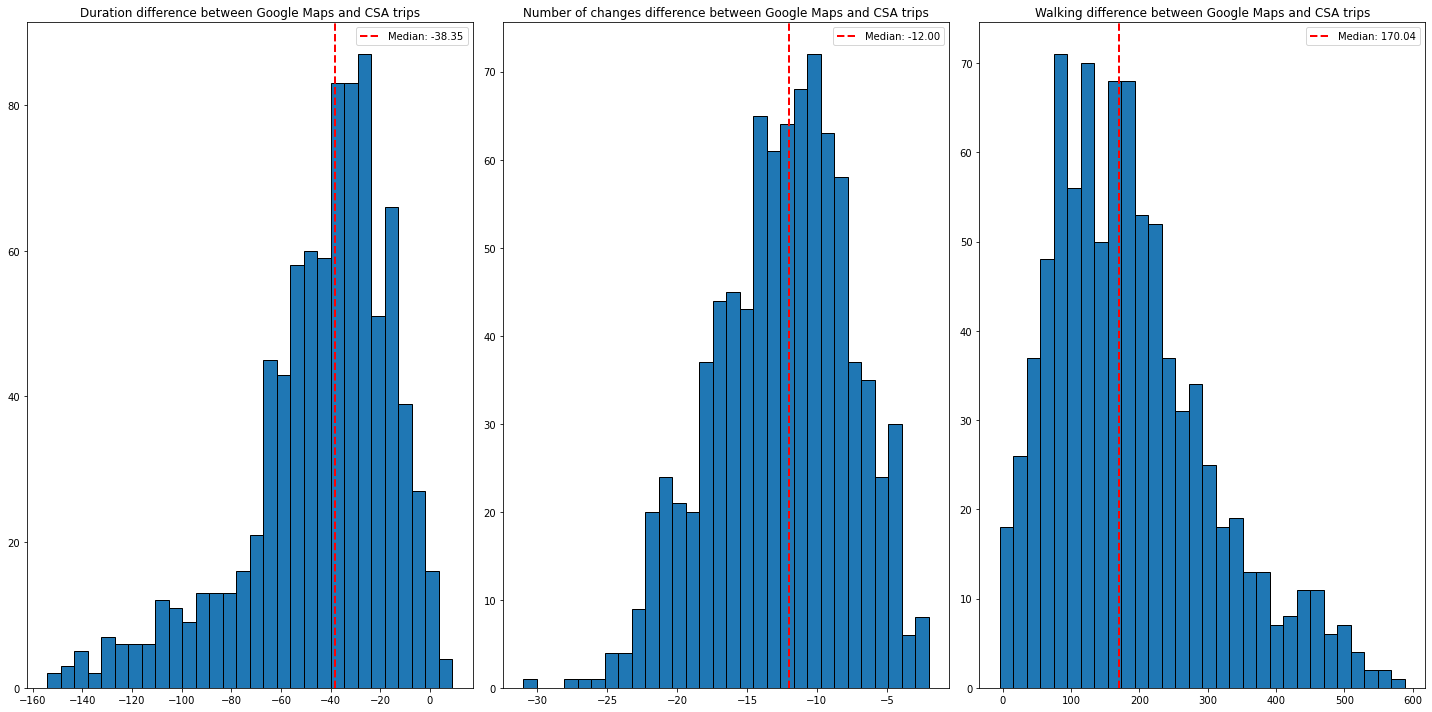

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots with histograms
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Plot histogram for duration
axs[0].hist(diff_duration_list, bins=30, edgecolor='black')
axs[0].set_title('Duration difference between Google Maps and CSA trips')

# Calculate median for duration
median_duration = np.median(diff_duration_list)
axs[0].axvline(median_duration, color='red', linestyle='dashed', linewidth=2)
axs[0].legend(['Median: {:.2f}'.format(median_duration)], loc='upper right')

# Plot histogram for number of changes
axs[1].hist(diff_nchanges_list, bins=30, edgecolor='black')
axs[1].set_title('Number of changes difference between Google Maps and CSA trips')

# Calculate median for number of changes
median_nchanges = np.median(diff_nchanges_list)
axs[1].axvline(median_nchanges, color='red', linestyle='dashed', linewidth=2)
axs[1].legend(['Median: {:.2f}'.format(median_nchanges)], loc='upper right')

# Plot histogram for walking time
axs[2].hist(diff_walking_list, bins=30, edgecolor='black')
axs[2].set_title('Walking difference between Google Maps and CSA trips')

# Calculate median for walking time
median_walking = np.median(diff_walking_list)
axs[2].axvline(median_walking, color='red', linestyle='dashed', linewidth=2)
axs[2].legend(['Median: {:.2f}'.format(median_walking)], loc='upper right')

# Adjust spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()
